### **0. Libraries, Functions**

In [2]:
# Libraries
#from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from os import path
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.gridspec as gridspec
from sklearn.ensemble import GradientBoostingClassifier

In [3]:
def evaluate(model):
    # Assuming df, mapping_df, rfs.feature_importances_, and X.columns are defined
    y_train_pred = model.predict(X_train)

    print(f'Train accuracy: {accuracy_score(y_train, y_train_pred)}\n')

    y_test_pred = model.predict(X_test)

    print(f'Test accuracy: {accuracy_score(y_test, y_test_pred)}\n')

    print(f'{classification_report(y_test, y_test_pred)}\n')

    # Color codes for each attribute type
    color_codes = {
        'intrinsic': '#1f77b4',
        'extrinsic': '#ff7f0e',
        'personal': '#7f7f7f'
    }

    # Creating a mapping of dummy feature names to attribute types
    attribute_type_mapping = dict(zip(mapping_df['dummy'], mapping_df['attribute_type']))

    # Creating a Series for feature importances
    feature_importance = pd.Series(
        data=model.feature_importances_,
        index=X.columns
    ).sort_values(ascending=False)

    # Set up the grid layout
    plt.figure(figsize=(15, 10))
    gs = gridspec.GridSpec(2, 4, height_ratios=[2, 1])

    # Main plot (top)
    top_30_features = feature_importance.nlargest(30)
    sorted_indices = np.argsort(top_30_features)
    sorted_features = top_30_features.index[sorted_indices]
    sorted_importances = top_30_features.values[sorted_indices]
    main_feature_colors = [color_codes.get(attribute_type_mapping.get(feature, 'personal'), '#7f7f7f') for feature in sorted_features]

    ax0 = plt.subplot(gs[0, :])
    ax0.barh(sorted_features, sorted_importances, color=main_feature_colors)
    ax0.set_xlabel('Importance')
    ax0.set_title('Top 30 Feature Importances')
    ax0.grid(True)
    legend_patches = [mpatches.Patch(color=color, label=atype) for atype, color in color_codes.items()]
    ax0.legend(handles=legend_patches, title="Attribute Types")

    # Subplots function for attribute types
    def create_subplot(attribute_type, subplot_position):
        filtered_importances = feature_importance[feature_importance.index.map(attribute_type_mapping) == attribute_type]
        top_filtered_features = filtered_importances.nlargest(10)
        sorted_indices = np.argsort(top_filtered_features)
        sorted_features = top_filtered_features.index[sorted_indices]
        sorted_importances = top_filtered_features.values[sorted_indices]

        ax = plt.subplot(gs[1, subplot_position])
        ax.barh(sorted_features, sorted_importances, color=color_codes[attribute_type])
        ax.set_xlabel('Importance')
        ax.set_title(f'Top 10 {attribute_type.capitalize()} Feature Importances')
        ax.grid(True)

    # Creating subplots for each attribute type
    create_subplot('intrinsic', 0)
    create_subplot('extrinsic', 1)
    create_subplot('personal', 2)

    # Adjust layout
    plt.tight_layout()
    plt.show()

### **1. Data import & pre-processing**

In [4]:
data_directory = '/Users/lukas/OneDrive/01_Projects/Conduct your own end-to-end analytics project/Code/Upload'

# features
wine_df = pd.read_csv(path.join(data_directory, 'wine_df_topic.csv'), low_memory=False)

In [5]:
wine_df.head()

,wine_id,wine,winery,region,wine_style,wine_style_description,ratings_average,ratings_number,all_vintage_ratings_average,all_vintage_ratings_count,...,user_total_given_ratings,user_total_sum_ratings,user_total_given_reviews,user_purchase_made,rating_label,date_review,time_review,review_len,review_word,assigned_topic
0,2144797,Adega Cooperativa de Borba Alentejano Galitos ...,Adega Cooperativa de Borba,Alentejano,Southern Portugal White,Southern Portugal is far better known for its ...,3.4,102,3.3,8988,...,53.0,198.4,53.0,0.0,3.5,2022-10-01,20:16:20,228,42,affordable
1,2144797,Adega Cooperativa de Borba Alentejano Galitos ...,Adega Cooperativa de Borba,Alentejano,Southern Portugal White,Southern Portugal is far better known for its ...,3.4,102,3.3,8988,...,155.0,554.1,129.0,0.0,3.5,2023-01-03,12:56:12,24,3,robust
2,2144797,Adega Cooperativa de Borba Alentejano Galitos ...,Adega Cooperativa de Borba,Alentejano,Southern Portugal White,Southern Portugal is far better known for its ...,3.4,102,3.3,8988,...,628.0,2280.0,500.0,0.0,4.0,2020-04-02,12:18:29,115,18,affordable
3,2144797,Adega Cooperativa de Borba Alentejano Galitos ...,Adega Cooperativa de Borba,Alentejano,Southern Portugal White,Southern Portugal is far better known for its ...,3.4,102,3.3,8988,...,472.0,1515.7,414.0,0.0,3.0,2015-06-12,14:04:45,177,32,vintage
4,2144797,Adega Cooperativa de Borba Alentejano Galitos ...,Adega Cooperativa de Borba,Alentejano,Southern Portugal White,Southern Portugal is far better known for its ...,3.4,102,3.3,8988,...,317.0,1229.3,289.0,2.0,4.0,2020-10-30,21:03:41,31,6,affordable


In [6]:
# check for cero
wine_df.isnull().sum().sum()

0

In [7]:
# check for duplicates
wine_df.duplicated().any()

False

In [8]:
# drop non meaningful
wine_df.drop(columns=['wine', 'winery', 'unique_id', 'review','date_review', 'time_review','review_id', 'wine_id', 'user_id'], axis=1, inplace=True)

In [9]:
wine_df.shape

(80021, 72)

### **2. Helpfunction**

In [10]:
# categorical
categorical = [var for var in wine_df.columns if wine_df[var].dtype=='O']

# numerical
numerical = [var for var in wine_df.columns if wine_df[var].dtype != 'O']

In [11]:
help_cat = wine_df[categorical]

dummies = pd.get_dummies(help_cat, columns=categorical)

original_features = ['_'.join(feature.split('_')[:-1]) for feature in list(dummies.columns)]

In [12]:
attribute_df = pd.read_csv(path.join('attribute_df.csv'), index_col=False)

In [13]:
dummy_df = pd.DataFrame({
    'original': original_features,
    'dummy': list(dummies.columns),
})

In [14]:
attribute_df_updated = attribute_df.copy()
dummy_df_updated = dummy_df.copy()

dummy_df_updated['attribute_type'] = None
dummy_df_updated['color'] = None

for i, row in dummy_df_updated.iterrows():
    original_feature = row['original']
    # Check if there's a matching feature in attribute_df_updated
    if original_feature in attribute_df_updated['feature'].values:
        # Find the corresponding attribute type and color
        attribute_type = attribute_df_updated[attribute_df_updated['feature'] == original_feature]['attribute_type'].values[0]
        color = attribute_df_updated[attribute_df_updated['feature'] == original_feature]['color'].values[0]
        dummy_df_updated.at[i, 'attribute_type'] = attribute_type
        dummy_df_updated.at[i, 'color'] = color
    else:
        # Keep the original feature if no match is found
        dummy_df_updated.at[i, 'attribute_type'] = 'original'
        dummy_df_updated.at[i, 'color'] = 'original'

In [15]:
# Deleting rows from the DataFrame where column values are in items_to_delete
df_filtered = attribute_df[~attribute_df['feature'].isin(categorical)]

df_filtered['original'] = df_filtered['feature']

df_filtered.rename({'feature': 'dummy'}, axis=1, inplace=True)

df_filtered = df_filtered[['original', 'dummy', 'attribute_type', 'color']]

C:\Users\lukas\AppData\Local\Temp\ipykernel_13288\631562097.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['original'] = df_filtered['feature']
C:\Users\lukas\AppData\Local\Temp\ipykernel_13288\631562097.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.rename({'feature': 'dummy'}, axis=1, inplace=True)


In [16]:
mapping_df = pd.concat([df_filtered, dummy_df_updated], axis=0).reset_index(drop=True)

In [17]:
mapping_df[['attribute_type','color']].value_counts()

attribute_type  color   
intrinsic       #1f77b4     111
extrinsic       #ff7f0e     109
personal        #7f7f7f      45
original        original      5
Name: count, dtype: int64

In [18]:
mapping_df[mapping_df['attribute_type'] == 'original']

,original,dummy,attribute_type,color
265,assigned_topic,assigned_topic_affordable,original,original
266,assigned_topic,assigned_topic_analytical,original,original
267,assigned_topic,assigned_topic_robust,original,original
268,assigned_topic,assigned_topic_sweet,original,original
269,assigned_topic,assigned_topic_vintage,original,original


In [19]:
mapping_df.loc[mapping_df['attribute_type'] == 'original', 'attribute_type'] = 'personal'
mapping_df.loc[mapping_df['color'] == 'original', 'color'] = '#7f7f7f'

In [20]:
mapping_df[['attribute_type','color']].value_counts()

attribute_type  color  
intrinsic       #1f77b4    111
extrinsic       #ff7f0e    109
personal        #7f7f7f     50
Name: count, dtype: int64

### **3. Feature Engineering**

In [21]:
# Create the X feature matrix and the y target vector
X = wine_df.drop(labels=['rating', 'rating_label'], axis=1)
y = wine_df['rating_label']

#### target

In [22]:
# encode the model to classify
manuel_encode = {1.0: 0, 1.5: 1,  2.0: 2, 2.5: 3, 3.0: 4, 3.5: 5, 4.0: 6,
                 4.5: 7 ,5.0: 8}

y = y.map(manuel_encode)

In [23]:
# final sense check
y.isna().sum()

0

In [24]:
# Label Encoding
X = pd.get_dummies(X, columns=categorical)

In [25]:
# check
X.head()

,ratings_average,ratings_number,all_vintage_ratings_average,all_vintage_ratings_count,price,acidity,sweetness,intensity,tannin,fizziness,...,user_language_sr,user_language_sv,user_language_tr,user_language_uk,user_language_zh,assigned_topic_affordable,assigned_topic_analytical,assigned_topic_robust,assigned_topic_sweet,assigned_topic_vintage
0,3.4,102,3.3,8988,3.49,2.712049,1.813505,2.997046,0.0,0.0,...,False,False,False,False,False,True,False,False,False,False
1,3.4,102,3.3,8988,3.49,2.712049,1.813505,2.997046,0.0,0.0,...,False,False,False,False,False,False,False,True,False,False
2,3.4,102,3.3,8988,3.49,2.712049,1.813505,2.997046,0.0,0.0,...,False,False,False,False,False,True,False,False,False,False
3,3.4,102,3.3,8988,3.49,2.712049,1.813505,2.997046,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
4,3.4,102,3.3,8988,3.49,2.712049,1.813505,2.997046,0.0,0.0,...,False,False,False,False,False,True,False,False,False,False


In [26]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.3,
                                                    random_state = 4,
                                                    stratify = y)

In [27]:
# create a manuel standardizer to ensure that naming process is correct
X_train_check= X_train.apply(lambda x: (x - x.mean()) / x.std())

#### categorical

In [28]:
X_train.shape

(56014, 259)

In [29]:
X_test.shape

(24007, 259)

In [30]:
X_train.isna().sum().sum()

0

In [31]:
X_test.isna().sum().sum()

0

In [32]:
# column train for later naming (verified with the check)
col_train = X_train.columns

# column test for later naming (verified with the check)
col_test = X_test.columns

In [33]:
col_train

Index(['ratings_average', 'ratings_number', 'all_vintage_ratings_average',
       'all_vintage_ratings_count', 'price', 'acidity', 'sweetness',
       'intensity', 'tannin', 'fizziness',
       ...
       'user_language_sr', 'user_language_sv', 'user_language_tr',
       'user_language_uk', 'user_language_zh', 'assigned_topic_affordable',
       'assigned_topic_analytical', 'assigned_topic_robust',
       'assigned_topic_sweet', 'assigned_topic_vintage'],
      dtype='object', length=259)

#### numerical

In [34]:
# standardize
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.fit_transform(X_test)

In [35]:
X_train = pd.DataFrame(X_train, columns=[col_train])
X_test = pd.DataFrame(X_test, columns=[col_test])

In [36]:
# see the standarized values
X_train.head()

,ratings_average,ratings_number,all_vintage_ratings_average,all_vintage_ratings_count,price,acidity,sweetness,intensity,tannin,fizziness,...,user_language_sr,user_language_sv,user_language_tr,user_language_uk,user_language_zh,assigned_topic_affordable,assigned_topic_analytical,assigned_topic_robust,assigned_topic_sweet,assigned_topic_vintage
0,-0.131679,-0.450592,-0.151778,-0.431039,-0.528192,2.474302,-2.237235,-0.968921,-0.656569,22.663104,...,-0.005976,-0.080764,-0.014638,-0.02276,-0.035625,1.509295,-0.368222,-0.548127,-0.535032,-0.372679
1,0.361262,0.124943,0.653993,-0.173910,0.185051,-0.551331,0.984182,0.481044,-0.656569,-0.044335,...,-0.005976,-0.080764,-0.014638,-0.02276,-0.035625,-0.662561,-0.368222,1.824394,-0.535032,-0.372679
2,0.032634,-0.456206,-0.554664,-0.677395,-0.408857,-0.444101,-0.878214,0.221796,1.352027,-0.044335,...,-0.005976,-0.080764,-0.014638,-0.02276,-0.035625,1.509295,-0.368222,-0.548127,-0.535032,-0.372679
3,0.361262,-0.441160,0.653993,-0.631923,-0.148834,2.473336,-1.123661,-2.010810,-0.656569,-0.044335,...,-0.005976,-0.080764,-0.014638,-0.02276,-0.035625,-0.662561,2.715750,-0.548127,-0.535032,-0.372679
4,0.196948,-0.258717,0.251108,-0.530583,-0.018194,-0.437483,0.933331,0.406260,-0.656569,-0.044335,...,-0.005976,-0.080764,-0.014638,-0.02276,-0.035625,-0.662561,-0.368222,-0.548127,1.869048,-0.372679


In [37]:
# see the manual calculated values to compare the correctness of the naming
X_train_check.head()

,ratings_average,ratings_number,all_vintage_ratings_average,all_vintage_ratings_count,price,acidity,sweetness,intensity,tannin,fizziness,...,user_language_sr,user_language_sv,user_language_tr,user_language_uk,user_language_zh,assigned_topic_affordable,assigned_topic_analytical,assigned_topic_robust,assigned_topic_sweet,assigned_topic_vintage
76039,-0.131678,-0.450588,-0.151777,-0.431035,-0.528187,2.474280,-2.237215,-0.968913,-0.656563,22.662902,...,-0.005975,-0.080763,-0.014638,-0.022759,-0.035625,1.509282,-0.368219,-0.548122,-0.535027,-0.372675
59478,0.361258,0.124942,0.653988,-0.173908,0.185050,-0.551326,0.984173,0.481040,-0.656563,-0.044335,...,-0.005975,-0.080763,-0.014638,-0.022759,-0.035625,-0.662555,-0.368219,1.824378,-0.535027,-0.372675
22324,0.032634,-0.456202,-0.554659,-0.677389,-0.408854,-0.444097,-0.878206,0.221794,1.352015,-0.044335,...,-0.005975,-0.080763,-0.014638,-0.022759,-0.035625,1.509282,-0.368219,-0.548122,-0.535027,-0.372675
46318,0.361258,-0.441156,0.653988,-0.631918,-0.148833,2.473314,-1.123651,-2.010792,-0.656563,-0.044335,...,-0.005975,-0.080763,-0.014638,-0.022759,-0.035625,-0.662555,2.715726,-0.548122,-0.535027,-0.372675
51153,0.196946,-0.258715,0.251105,-0.530579,-0.018194,-0.437479,0.933323,0.406256,-0.656563,-0.044335,...,-0.005975,-0.080763,-0.014638,-0.022759,-0.035625,-0.662555,-0.368219,-0.548122,1.869032,-0.372675


In [1]:
X_train.describe()[1:3].T

NameError: name 'X_train' is not defined

### **4. Modeling**

#### a. Random Forest

##### i. simple

In [38]:
rfs = RandomForestClassifier(random_state=0)

# fit the model to the training set
rfs.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

<bound method BaseEstimator.get_params of RandomForestClassifier(random_state=0)>

Train accuracy: 1.0

Test accuracy: 0.44770275336360227

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       130
           1       0.00      0.00      0.00        60
           2       0.12      0.01      0.01       326
           3       0.11      0.01      0.02       445
           4       0.21      0.07      0.10      2249
           5       0.36      0.28      0.32      4454
           6       0.49      0.79      0.60     10477
           7       0.39      0.20      0.27      3395
           8       0.40      0.16      0.23      2471

    accuracy                           0.45     24007
   macro avg       0.23      0.17      0.17     24007
weighted avg       0.40      0.45      0.39     24007




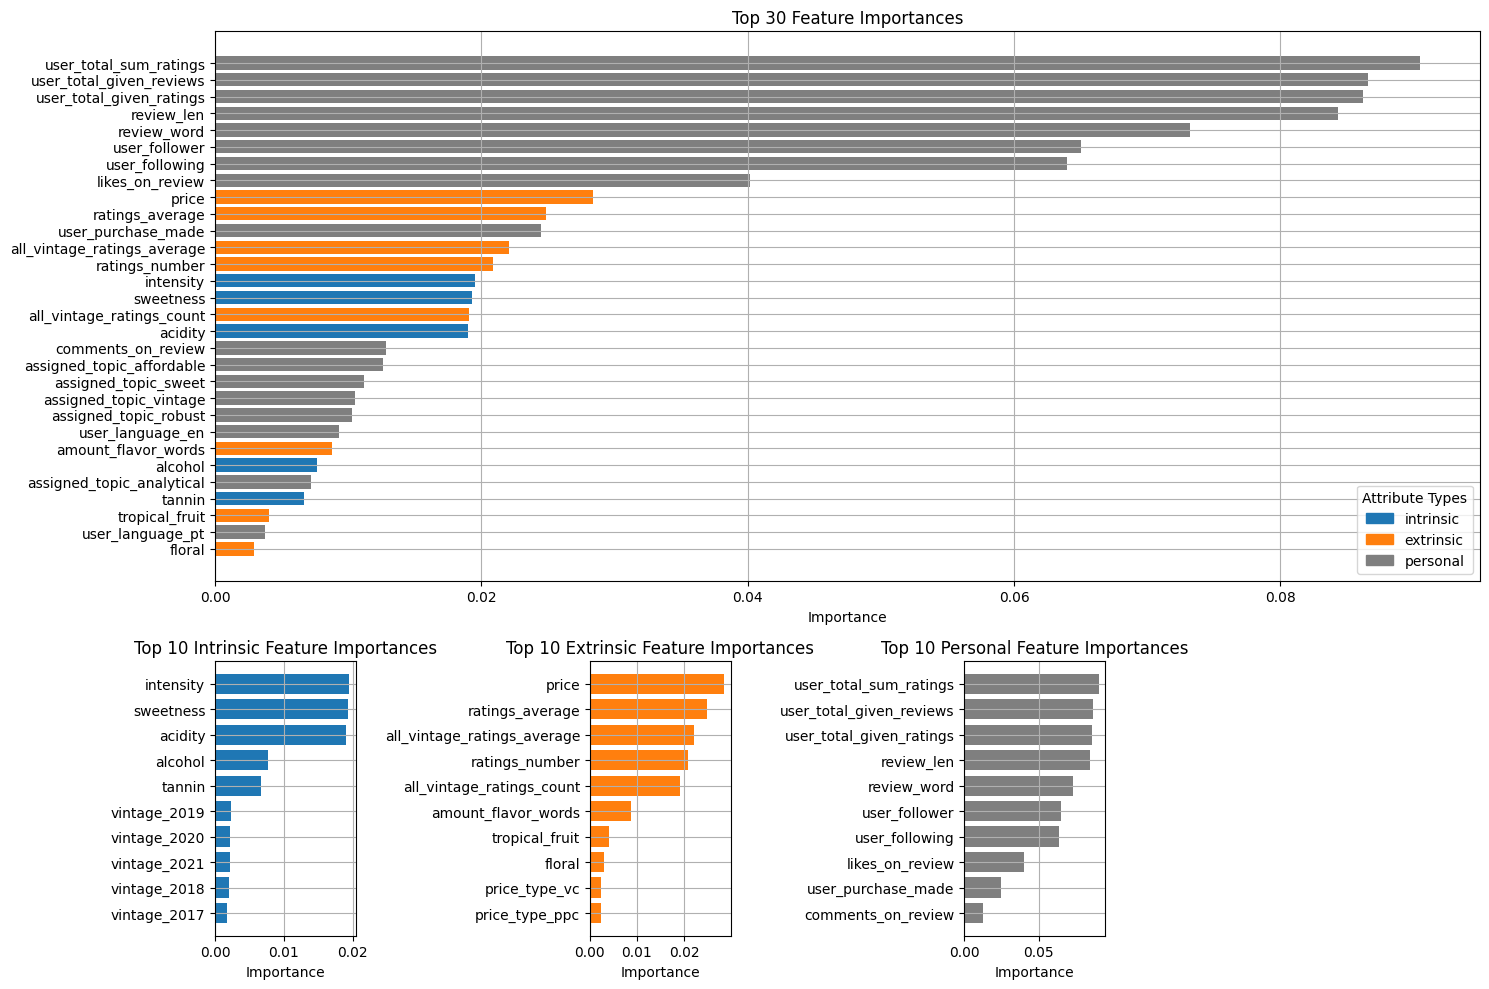

In [44]:
evaluate(rfs)

##### ii. Hypertuning - Optuna

In [38]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [78]:
import optuna
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np


import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score

def objective(trial):
    # Suggested hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 400),
        'max_depth': trial.suggest_int('max_depth', 5, 35),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'criterion': trial.suggest_categorical('criterion', ['entropy']),
        'max_samples': trial.suggest_float('max_samples', 0.1, 1.0),
        'random_state': 0,
    }

    # Creating the RandomForest model
    model = RandomForestClassifier(**params, bootstrap=True)

     # Stratified K-Fold cross-validator
    skf = StratifiedKFold(n_splits=5)

    # Custom scoring function for multi-class ROC AUC
    roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True, multi_class='ovr')

    # Perform cross-validation on the training set
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring=roc_auc_scorer)

    # Average ROC AUC score across all folds
    return scores.mean()

# Early stopping callback
def early_stopping_callback(study, trial):
    if study.best_trial.number + 10 <= trial.number:
        study.stop()

# Create a study and optimize
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, callbacks=[early_stopping_callback])

# Retrieve the best model
best_model = RandomForestClassifier(**study.best_params, random_state=42)
best_model.fit(X_train, y_train)  # Fit on the entire training set

evaluate(best_model)

[I 2023-11-28 09:15:17,371] A new study created in memory with name: no-name-6abcf8e6-b95f-4278-91d6-8589af8daee7
[I 2023-11-28 10:44:40,653] Trial 0 finished with value: 0.7414679195752686 and parameters: {'n_estimators': 281, 'max_depth': 25, 'min_samples_split': 18, 'max_features': None, 'criterion': 'entropy', 'max_samples': 0.8206647965373611}. Best is trial 0 with value: 0.7414679195752686.
[I 2023-11-28 10:49:44,535] Trial 1 finished with value: 0.7364800472147084 and parameters: {'n_estimators': 281, 'max_depth': 16, 'min_samples_split': 10, 'max_features': 'log2', 'criterion': 'entropy', 'max_samples': 0.716512164131043}. Best is trial 0 with value: 0.7414679195752686.
[I 2023-11-28 10:54:09,302] Trial 2 finished with value: 0.7340766080141365 and parameters: {'n_estimators': 309, 'max_depth': 15, 'min_samples_split': 2, 'max_features': 'log2', 'criterion': 'entropy', 'max_samples': 0.4075402751607975}. Best is trial 0 with value: 0.7414679195752686.
[I 2023-11-28 10:58:17,716

Train accuracy: 0.49673295961723857

Test accuracy: 0.47219560961386264

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       130
           1       0.00      0.00      0.00        60
           2       0.00      0.00      0.00       326
           3       0.00      0.00      0.00       445
           4       0.36      0.00      0.00      2249
           5       0.40      0.27      0.32      4454
           6       0.49      0.86      0.62     10477
           7       0.46      0.21      0.28      3395
           8       0.48      0.14      0.22      2471

    accuracy                           0.47     24007
   macro avg       0.24      0.17      0.16     24007
weighted avg       0.43      0.47      0.39     24007




c:\Users\lukas\anaconda3\envs\py311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\lukas\anaconda3\envs\py311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\lukas\anaconda3\envs\py311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



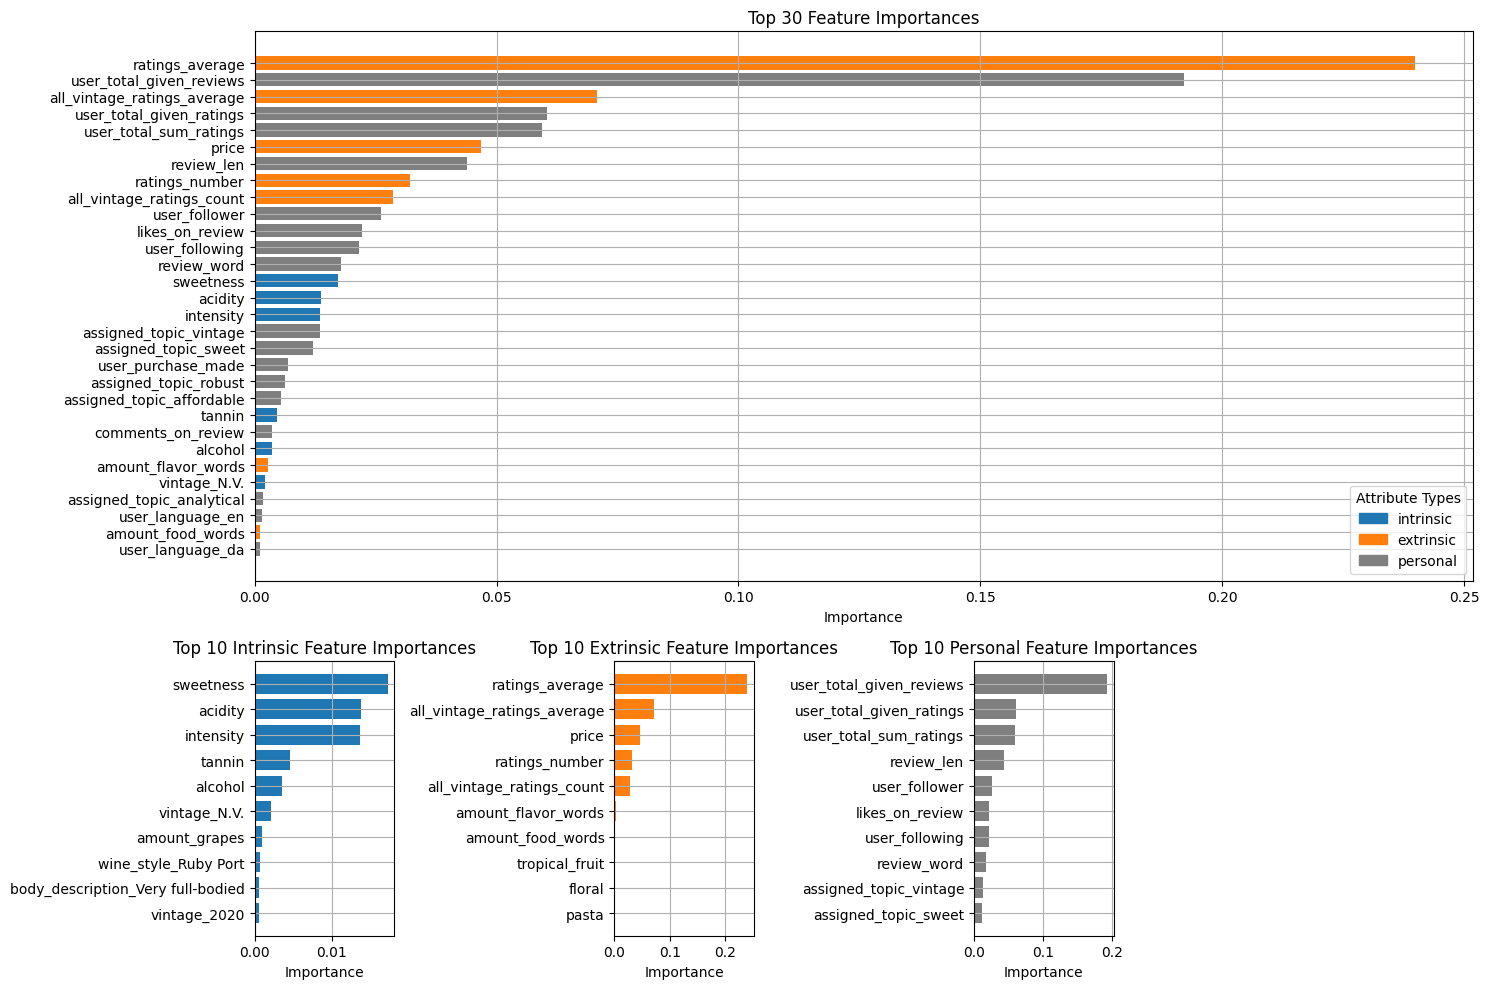

In [79]:
# Create a study and optimize
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, callbacks=[early_stopping_callback])

# Retrieve the best model
best_model = RandomForestClassifier(**study.best_params, random_state=0)
best_model.fit(X_train, y_train)  # Fit on the entire training set

evaluate(best_model)

In [80]:
print(study.best_params)

{'n_estimators': 385, 'max_depth': 9, 'min_samples_split': 19, 'max_features': None, 'criterion': 'entropy', 'max_samples': 0.4828174651810347}


#### ii. AdaBoost

##### a. simple

In [56]:
# Import the AdaBoost classifier
from sklearn.ensemble import AdaBoostClassifier

# Create adaboost classifer object
abc = AdaBoostClassifier(random_state=0)

# Train Adaboost Classifer
abc.fit(X_train, y_train)

# Predict probabilities
y_prob = abc.predict_proba(X_train)

# Binarize the output (one-hot encoding)
y_test_binarized = label_binarize(y_train, classes=np.unique(y_train))

# Compute ROC AUC for each class
roc_auc = {}
for i in range(y_test_binarized.shape[1]):
    roc_auc[i] = roc_auc_score(y_test_binarized[:, i], y_prob[:, i])

# Calculate average ROC AUC
average_roc_auc = np.mean(list(roc_auc.values()))

print("ROC AUC for each class:", roc_auc)
print("Average ROC AUC:", average_roc_auc)

AdaBoostClassifier(random_state=0)

ROC AUC for each class: {0: 0.8413069561356271, 1: 0.8695096647514203, 2: 0.7331169821544583, 3: 0.6584075538444802, 4: 0.5853015773202104, 5: 0.6412342003391145, 6: 0.5768051693164911, 7: 0.693497384557239, 8: 0.7581058097517894}
Average ROC AUC: 0.7063650331300922


Train accuracy: 0.46408710322419394

Test accuracy: 0.46210559200249923

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        87
           1       0.00      0.00      0.00        40
           2       0.00      0.00      0.00       217
           3       0.00      0.00      0.00       297
           4       0.29      0.00      0.00      1499
           5       0.38      0.22      0.28      2970
           6       0.48      0.89      0.62      6984
           7       0.41      0.13      0.20      2264
           8       0.46      0.12      0.19      1647

    accuracy                           0.46     16005
   macro avg       0.22      0.15      0.14     16005
weighted avg       0.41      0.46      0.37     16005




c:\Users\lukas\anaconda3\envs\py311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\lukas\anaconda3\envs\py311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\lukas\anaconda3\envs\py311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


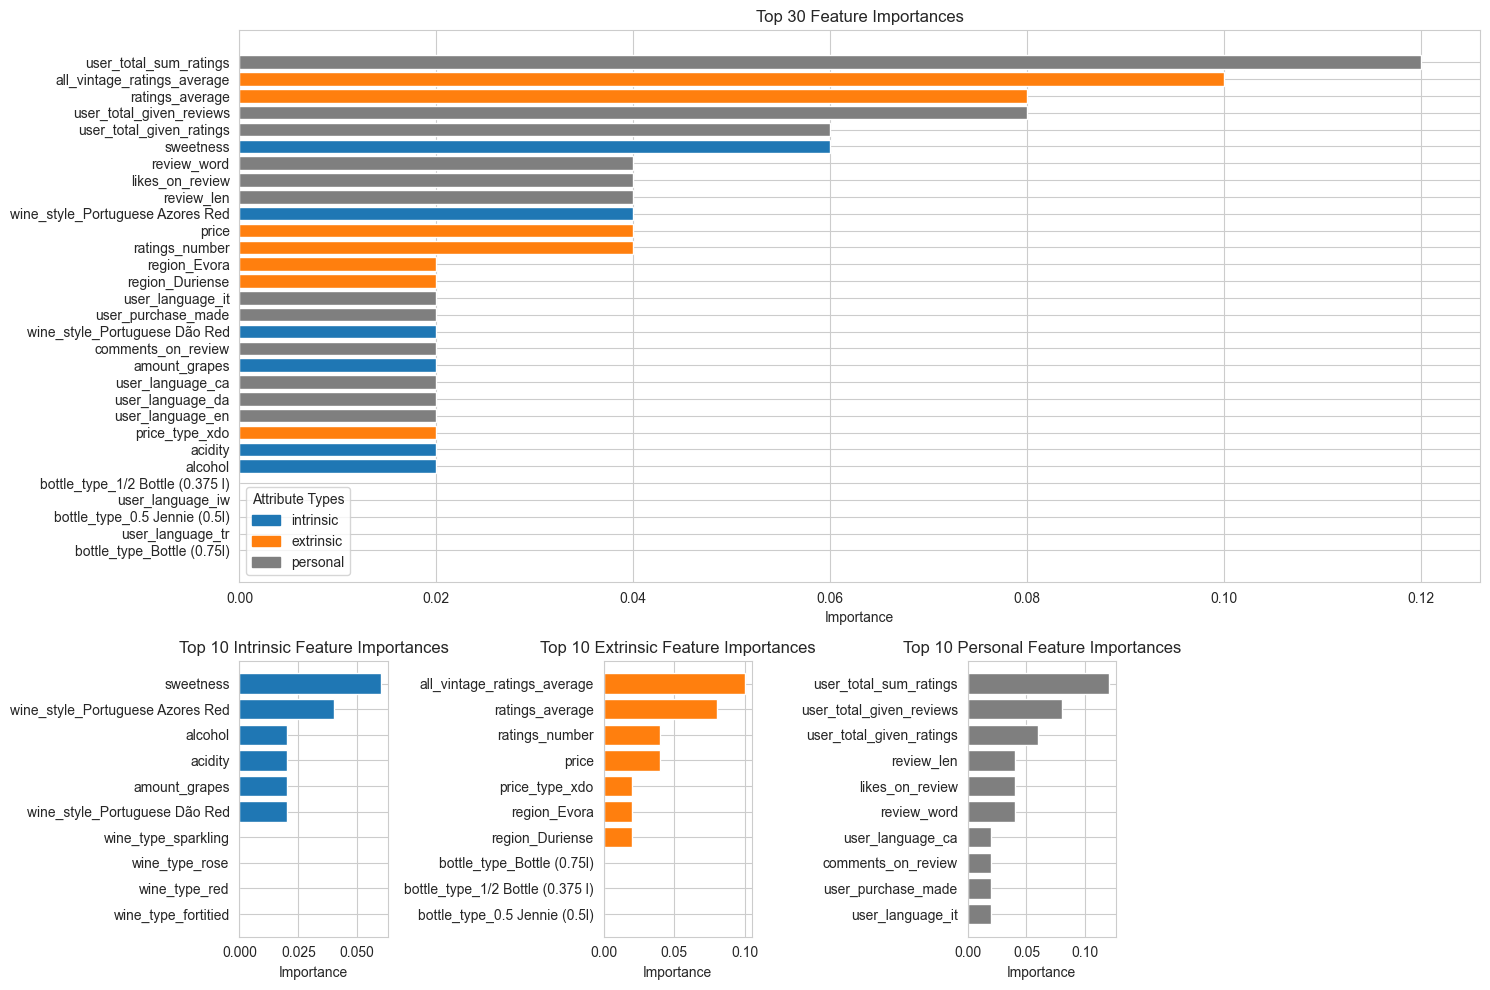

In [44]:
evaluate(abc)

##### b. Hypertuning

<!-- #### b. Hypertuning -->

In [110]:
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, make_scorer

def objective(trial):
    # Suggested hyperparameters for AdaBoost
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 350),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 1),
        'estimator': DecisionTreeClassifier(
            max_depth=trial.suggest_int('base_estimator_max_depth', 1, 10),
            min_samples_split=trial.suggest_int('min_samples_split', 2, 20)
        ),
        'algorithm': trial.suggest_categorical('algorithm', ['SAMME', 'SAMME.R']),
        'random_state': 0
    }

    # Creating the AdaBoost model
    model = AdaBoostClassifier(**params)

    # Stratified K-Fold cross-validator
    skf = StratifiedKFold(n_splits=5)

    # Stratified K-Fold cross-validator
    skf = StratifiedKFold(n_splits=5)

    # Custom scoring function for multi-class ROC AUC
    roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True, multi_class='ovr')

    # Perform cross-validation on the training set
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring=roc_auc_scorer)

    # Average ROC AUC score across all folds
    return scores.mean()

# Early stopping callback
def early_stopping_callback(study, trial):
    if study.best_trial.number + 10 <= trial.number:
        study.stop()


In [111]:
# Create a study and optimize
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, callbacks=[early_stopping_callback])

# Retrieve the best model
ada_model = RandomForestClassifier(**study.best_params, random_state=0)
ada_model.fit(X_train, y_train)  # Fit on the entire training set

evaluate(ada_model)

[I 2023-11-30 09:04:44,024] A new study created in memory with name: no-name-ec7ee25c-d6f5-485b-a97e-6425b140b600
[I 2023-11-30 09:07:16,315] Trial 0 finished with value: 0.7170292551335342 and parameters: {'n_estimators': 44, 'learning_rate': 0.9384730820630282, 'base_estimator_max_depth': 3, 'min_samples_split': 19, 'algorithm': 'SAMME'}. Best is trial 0 with value: 0.7170292551335342.
[I 2023-11-30 10:02:18,090] Trial 1 finished with value: 0.6792277193039633 and parameters: {'n_estimators': 282, 'learning_rate': 0.48276168846024814, 'base_estimator_max_depth': 8, 'min_samples_split': 11, 'algorithm': 'SAMME.R'}. Best is trial 0 with value: 0.7170292551335342.
[I 2023-11-30 10:07:42,403] Trial 2 finished with value: 0.7160495445943776 and parameters: {'n_estimators': 175, 'learning_rate': 0.9710895668550875, 'base_estimator_max_depth': 1, 'min_samples_split': 15, 'algorithm': 'SAMME'}. Best is trial 0 with value: 0.7170292551335342.
[I 2023-11-30 10:49:04,040] Trial 3 finished with 

TypeError: RandomForestClassifier.__init__() got an unexpected keyword argument 'learning_rate'

In [112]:
print(study.best_params)

{'n_estimators': 203, 'learning_rate': 0.12532561575592083, 'base_estimator_max_depth': 4, 'min_samples_split': 11, 'algorithm': 'SAMME'}


In [93]:
AdaBoostClassifier(study.best_params)

AdaBoostClassifier(estimator={'algorithm': 'SAMME',
                              'base_estimator_max_depth': 5,
                              'learning_rate': 0.10984192033537354,
                              'n_estimators': 251})

Train accuracy: 0.4890563073517335

Test accuracy: 0.458199691756571

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       130
           1       0.00      0.00      0.00        60
           2       0.00      0.00      0.00       326
           3       0.00      0.00      0.00       445
           4       0.28      0.04      0.07      2249
           5       0.38      0.30      0.33      4454
           6       0.48      0.84      0.61     10477
           7       0.40      0.16      0.23      3395
           8       0.42      0.11      0.17      2471

    accuracy                           0.46     24007
   macro avg       0.22      0.16      0.16     24007
weighted avg       0.41      0.46      0.39     24007




c:\Users\lukas\anaconda3\envs\py311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\lukas\anaconda3\envs\py311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\lukas\anaconda3\envs\py311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



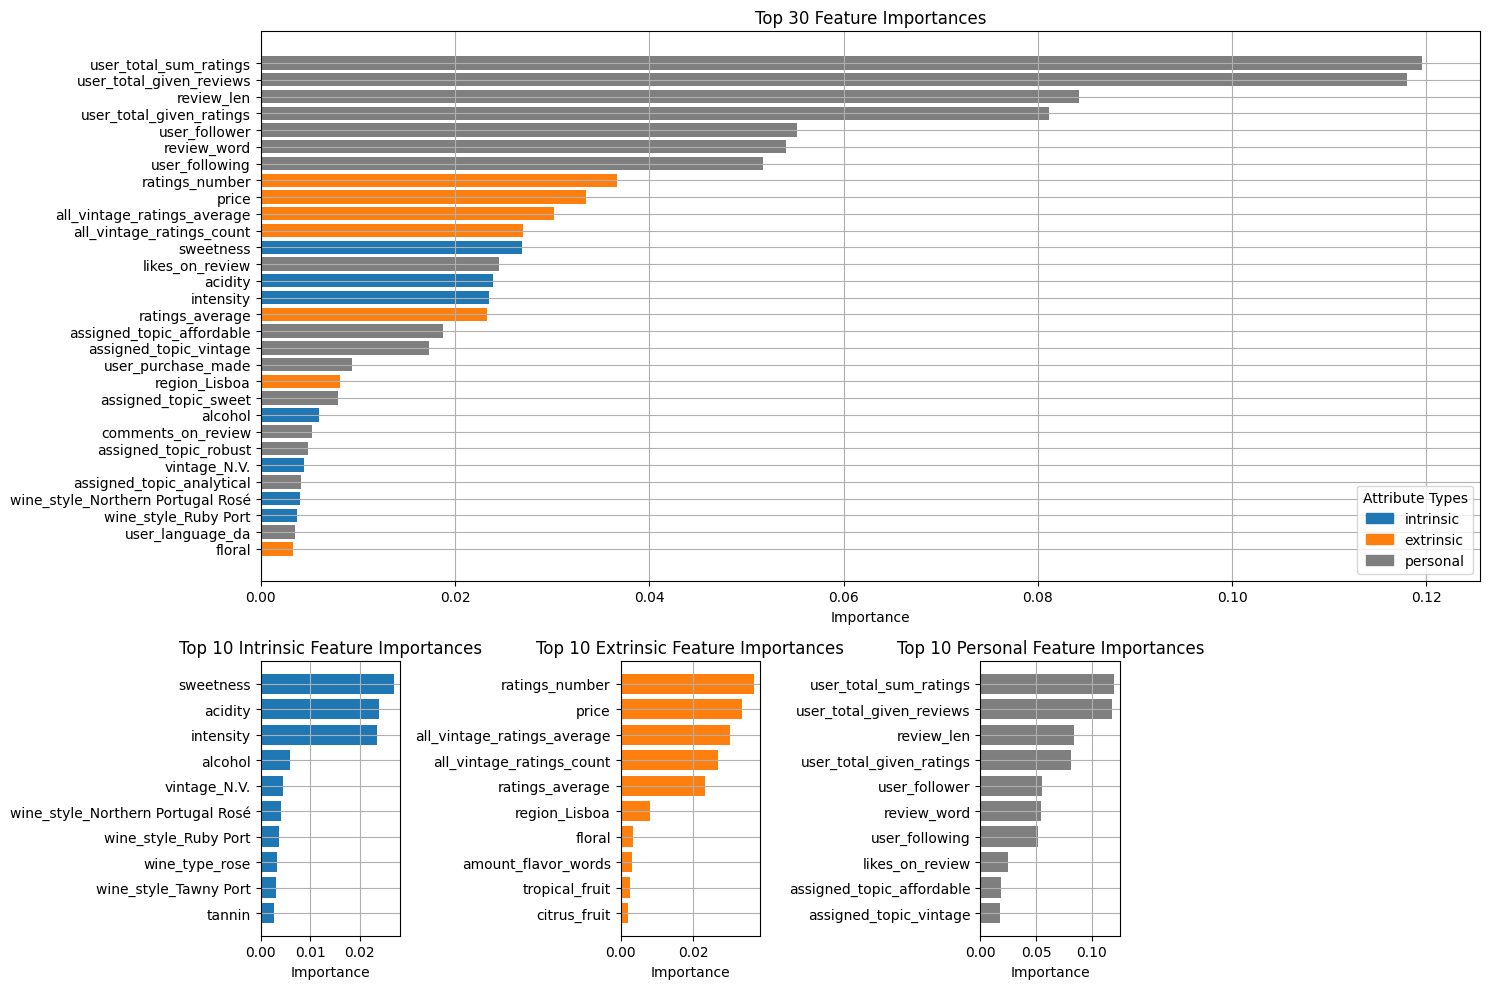

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Set up the base estimator
base_estimator = DecisionTreeClassifier(max_depth=study.best_params['base_estimator_max_depth'])

# Initialize AdaBoost with the base estimator
ada_model = AdaBoostClassifier(estimator=base_estimator,
                               n_estimators=study.best_params['n_estimators'],
                               learning_rate=study.best_params['learning_rate'],
                               random_state=42)

# Fit the model
ada_model.fit(X_train, y_train)

evaluate(ada_model)

In [113]:
from joblib import dump

# The filename of the model
filename = 'ada_model.joblib'

# Combine the folder path and the filename
full_path = data_directory + filename

# Save the model to the specified folder
dump(ada_model, full_path)


['/Users/lukas/OneDrive/01_Projects/Conduct your own end-to-end analytics project/Code/Uploadada_model.joblib']

In [115]:
# Import optuna.visualization
import optuna.visualization as vis

# Plot optimization history
vis.plot_optimization_history(study)

# Plot parameter importance
vis.plot_param_importances(study)

#### iii. Gradient Boosting

##### a. simple

In [57]:
from sklearn.ensemble import GradientBoostingClassifier

# Instantiate gbc (GradientBoostingClassifier)
gbc = GradientBoostingClassifier()

# Fit gbc to the training set
gbc.fit(X_train, y_train)

GradientBoostingClassifier()

Train accuracy: 0.5035883886171314

Test accuracy: 0.46936310242845836

              precision    recall  f1-score   support

           0       0.07      0.01      0.01       130
           1       0.00      0.00      0.00        60
           2       0.03      0.00      0.01       326
           3       0.08      0.00      0.01       445
           4       0.28      0.03      0.06      2249
           5       0.40      0.27      0.32      4454
           6       0.49      0.85      0.62     10477
           7       0.44      0.20      0.27      3395
           8       0.46      0.16      0.24      2471

    accuracy                           0.47     24007
   macro avg       0.25      0.17      0.17     24007
weighted avg       0.42      0.47      0.40     24007




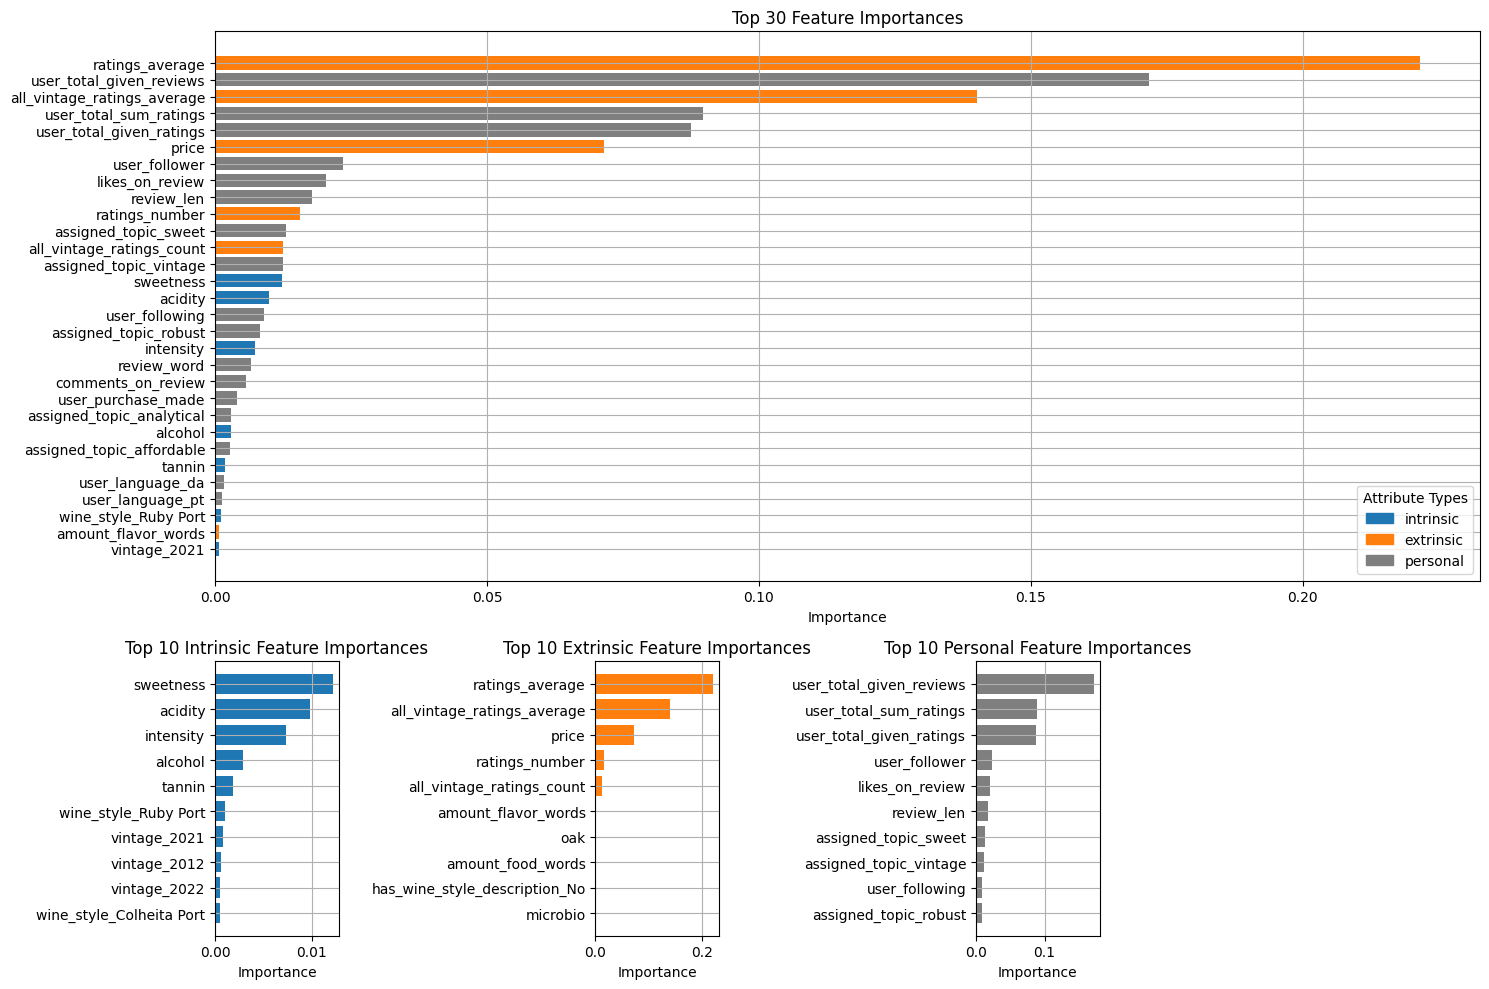

In [58]:
evaluate(gbc)

In [40]:
import optuna
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, roc_auc_score

def objective(trial):
    # Suggest values for hyperparameters
    n_estimators = trial.suggest_int("n_estimators", 50, 100)
    max_depth = trial.suggest_int("max_depth", 2, 10)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.1, log=True)
    subsample = trial.suggest_float("subsample", 0.6, 0.9)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])

    params = {
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'subsample': subsample,
        'min_samples_split': min_samples_split,
        'max_features': max_features
    }

    # Creating the GradientBoostingClassifier model
    model = GradientBoostingClassifier(**params)

    # Stratified K-Fold cross-validator
    skf = StratifiedKFold(n_splits=5)

    # Custom scoring function for multi-class ROC AUC
    roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True, multi_class='ovr')

    # Perform cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring=roc_auc_scorer)

    # Average ROC AUC score across all folds
    return scores.mean()

# Early stopping callback
def early_stopping_callback(study, trial):
    if study.best_trial.number + 10 <= trial.number:
        study.stop()

In [42]:
print(study.best_params)

{'n_estimators': 88, 'max_depth': 7, 'learning_rate': 0.018534979647709726, 'subsample': 0.7234372402089758, 'min_samples_split': 17, 'max_features': None}


In [118]:
# Create a study and optimize
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, callbacks=[early_stopping_callback])

# Retrieve the best model
best_model = GradientBoostingClassifier(**study.best_params, random_state=0)
best_model.fit(X_train, y_train)

evaluate(best_model)

[I 2023-11-30 20:12:15,137] A new study created in memory with name: no-name-50ee4d9c-3ee5-4ad3-a2de-5ddabb051f75
[I 2023-11-30 21:07:09,537] Trial 0 finished with value: 0.7567451389199916 and parameters: {'n_estimators': 80, 'max_depth': 7, 'learning_rate': 0.03269216820786294, 'subsample': 0.6245062851447977, 'min_samples_split': 12, 'max_features': None}. Best is trial 0 with value: 0.7567451389199916.
[I 2023-11-30 21:12:08,809] Trial 1 finished with value: 0.7484047959724471 and parameters: {'n_estimators': 72, 'max_depth': 7, 'learning_rate': 0.08110436611259969, 'subsample': 0.7605407899188651, 'min_samples_split': 11, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7567451389199916.
[I 2023-11-30 21:14:00,498] Trial 2 finished with value: 0.7361606985252023 and parameters: {'n_estimators': 63, 'max_depth': 6, 'learning_rate': 0.011041575239448929, 'subsample': 0.6195162922109521, 'min_samples_split': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.756745138919

[I 2023-12-01 04:08:41,672] A new study created in memory with name: no-name-ca10013b-5d1d-4370-804c-0d3421b339e5
[I 2023-12-01 04:17:50,498] Trial 0 finished with value: 0.730215445512659 and parameters: {'n_estimators': 80, 'max_depth': 2, 'learning_rate': 0.01443255484338562, 'subsample': 0.7025505834473458, 'min_samples_split': 11, 'max_features': None}. Best is trial 0 with value: 0.730215445512659.
[I 2023-12-01 04:20:10,999] Trial 1 finished with value: 0.7403739029012322 and parameters: {'n_estimators': 97, 'max_depth': 6, 'learning_rate': 0.01096302713903354, 'subsample': 0.6975758771219189, 'min_samples_split': 12, 'max_features': 'log2'}. Best is trial 1 with value: 0.7403739029012322.
[I 2023-12-01 04:23:03,287] Trial 2 finished with value: 0.7458512609828907 and parameters: {'n_estimators': 93, 'max_depth': 7, 'learning_rate': 0.014699180307397499, 'subsample': 0.872973809240863, 'min_samples_split': 6, 'max_features': 'log2'}. Best is trial 2 with value: 0.745851260982890

GradientBoostingClassifier(learning_rate=0.018534979647709726, max_depth=7,
                           min_samples_split=17, n_estimators=88,
                           random_state=0, subsample=0.7234372402089758)

Train accuracy: 0.5237083586246296

Test accuracy: 0.47011288374224186

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       130
           1       0.00      0.00      0.00        60
           2       0.06      0.00      0.01       326
           3       0.06      0.00      0.00       445
           4       0.21      0.01      0.02      2249
           5       0.41      0.24      0.30      4454
           6       0.48      0.89      0.62     10477
           7       0.47      0.17      0.25      3395
           8       0.48      0.13      0.20      2471

    accuracy                           0.47     24007
   macro avg       0.24      0.16      0.16     24007
weighted avg       0.42      0.47      0.39     24007




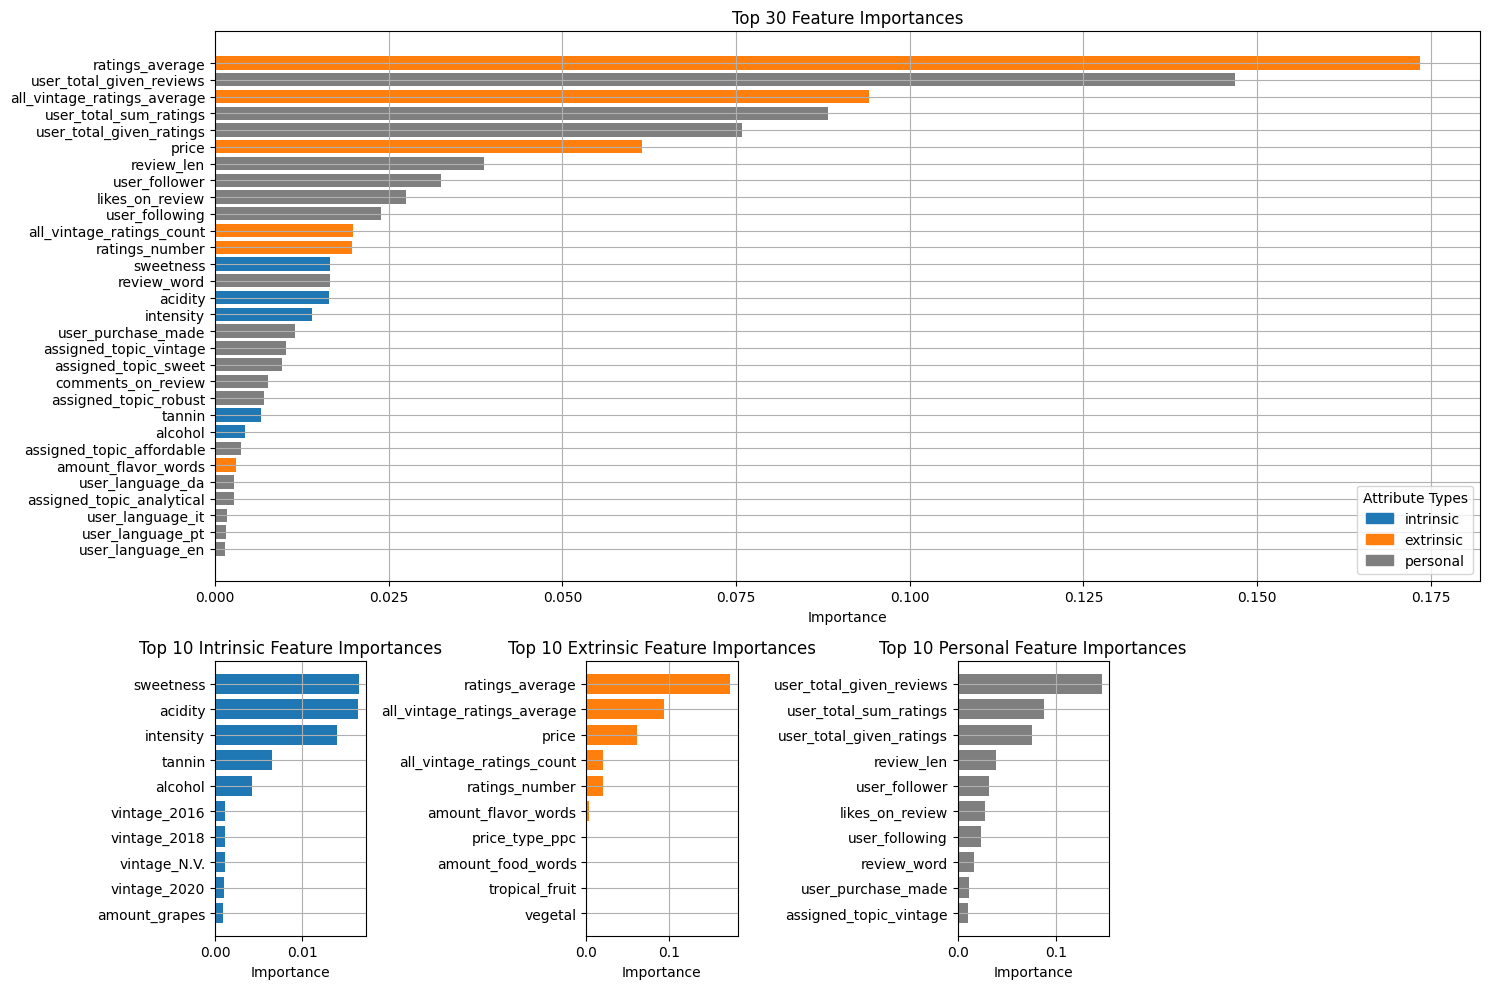

In [41]:
# Create a study and optimize
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, callbacks=[early_stopping_callback])

# Retrieve the best model
best_model = GradientBoostingClassifier(**study.best_params, random_state=0)
best_model.fit(X_train, y_train)

evaluate(best_model)

In [50]:
import joblib

model_path = '/Users/lukas/OneDrive/01_Projects/Conduct your own end-to-end analytics project/Code/Upload/Model/gradient_model.pkl'


# Assuming best_model is your trained model
joblib.dump(best_model, model_path)


loaded_model = joblib.load(model_path)

['/Users/lukas/OneDrive/01_Projects/Conduct your own end-to-end analytics project/Code/Upload/Model/gradient_model.pkl']

Train accuracy: 0.5237083586246296

Test accuracy: 0.47011288374224186

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       130
           1       0.00      0.00      0.00        60
           2       0.06      0.00      0.01       326
           3       0.06      0.00      0.00       445
           4       0.21      0.01      0.02      2249
           5       0.41      0.24      0.30      4454
           6       0.48      0.89      0.62     10477
           7       0.47      0.17      0.25      3395
           8       0.48      0.13      0.20      2471

    accuracy                           0.47     24007
   macro avg       0.24      0.16      0.16     24007
weighted avg       0.42      0.47      0.39     24007




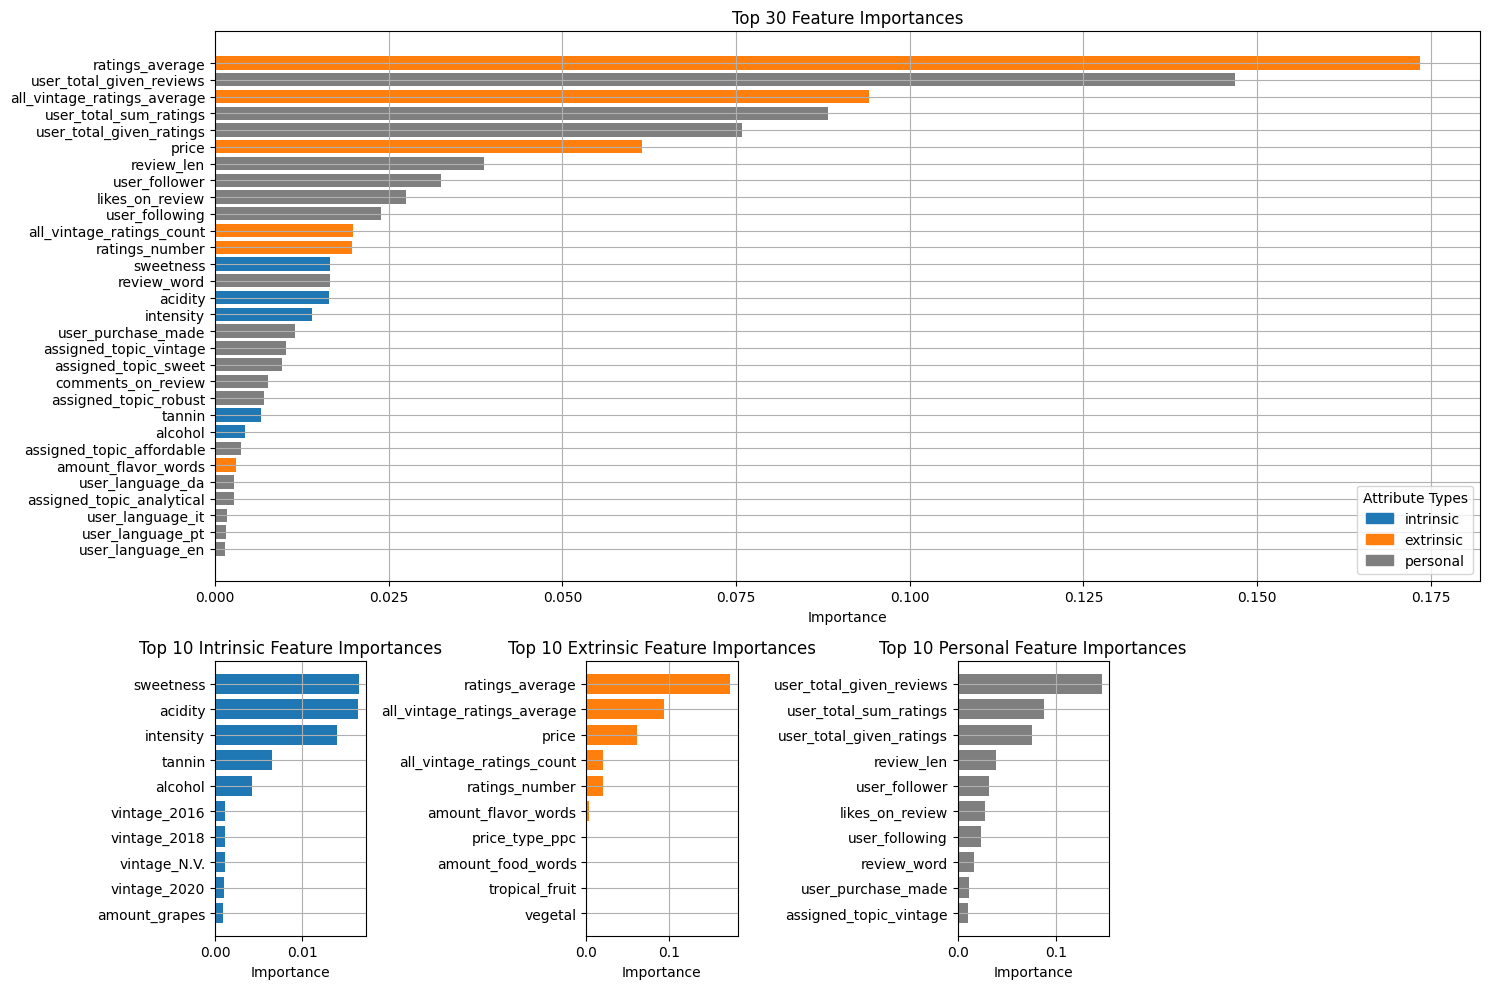

In [51]:
evaluate(loaded_model)

##### b. Hypertuning

#### v. XGBoosting

In [85]:
# import XGBClassifier
from xgboost import XGBClassifier


# declare parameters
params = {
    'objective': 'multi:softmax',  # Use 'multi:softmax' for multi-class classification
    'num_class': 9             # Number of classes
}


X_train = X_train.rename(columns=lambda x: x.replace('[', '').replace(']', '').replace('<', '').replace(' ', '_'))
X_test = X_test.rename(columns=lambda x: x.replace('[', '').replace(']', '').replace('<', '').replace(' ', '_'))

# instantiate the classifier
xgb_clf = XGBClassifier(**params)


# fit the classifier to the training data
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=9,
              num_parallel_tree=None, ...)

Train accuracy: 0.5983972756810797

Test accuracy: 0.47403936269915653

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        87
           1       0.00      0.00      0.00        40
           2       0.00      0.00      0.00       217
           3       0.11      0.01      0.01       297
           4       0.28      0.06      0.10      1499
           5       0.40      0.33      0.36      2970
           6       0.50      0.83      0.62      6984
           7       0.44      0.18      0.26      2264
           8       0.52      0.18      0.27      1647

    accuracy                           0.47     16005
   macro avg       0.25      0.18      0.18     16005
weighted avg       0.43      0.47      0.41     16005




c:\Users\lukas\anaconda3\envs\py311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\lukas\anaconda3\envs\py311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\lukas\anaconda3\envs\py311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


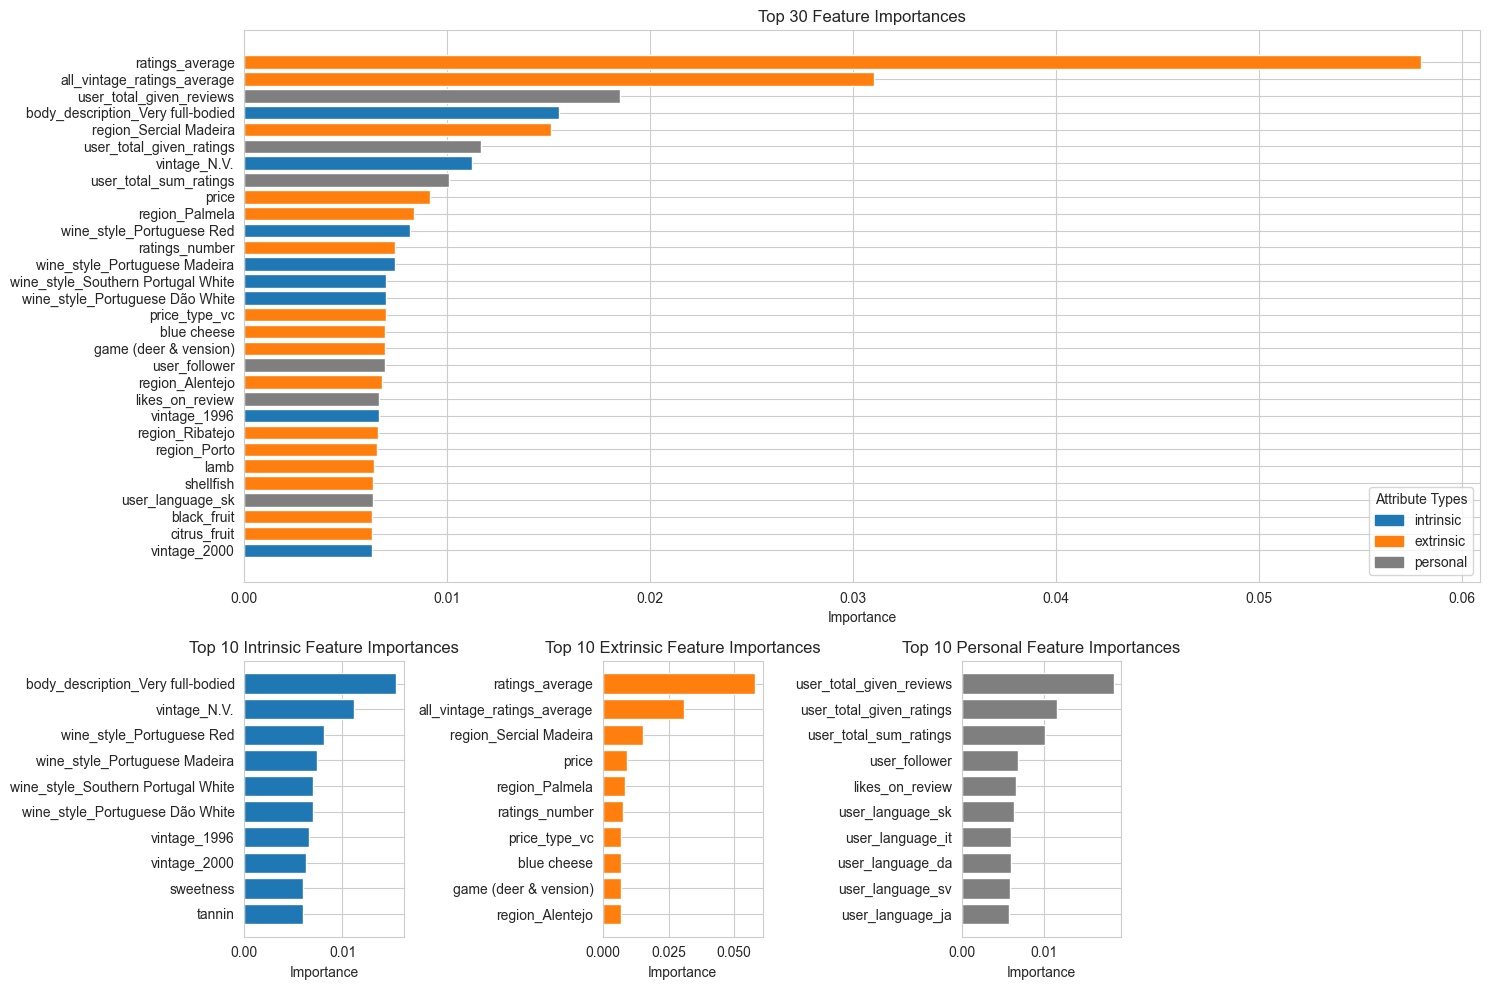

In [86]:
evaluate(xgb_clf)

###### Bayes Optimization

In [31]:
import optuna
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm

best_accuracy = 0  # Initialize the best accuracy
best_model = None  # Initialize the best model

def objective(trial):
    global best_accuracy  # Declare the global variable to modify it within the function
    global best_model
    # Suggest values for hyperparameters
    n_estimators = trial.suggest_int("n_estimators", 10, 200, log=True)
    max_depth = trial.suggest_int("max_depth", 2, 32)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.1)
    min_child_weight = trial.suggest_int("min_child_weight", 1, 10)
    subsample = trial.suggest_float("subsample", 0.1, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.1, 1.0)
    gamma = trial.suggest_float("gamma", 1e-8, 1.0)
    alpha = trial.suggest_float("alfa", 0.1, 1.0)  # Custom "alfa" parameter

    # Create an XGBoost model with hyperparameters
    clf = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        alpha=alpha,  # Include the custom "alfa" parameter
        random_state=42
    )

    # Perform cross-validation
    cv_results = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')

    # Calculate the mean cross-validated accuracy
    accuracy = cv_results.mean()

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = clf
        print("Improvement")

    # Return accuracy as the evaluation metric and criteria
    return accuracy

In [32]:
# Example usage
study = optuna.create_study(direction="maximize")
with tqdm(total=100) as pbar:  # Set the total number of trials
    def update_progress_bar(study, trial):
        pbar.update(1)

    study.optimize(objective, n_trials=100, callbacks=[update_progress_bar])

print("Best Accuracy: {:.2f}%".format(best_accuracy * 100))
print("Best Parameters:", best_model.get_params())

[I 2023-11-11 18:47:46,763] A new study created in memory with name: no-name-7ecbdfa1-7f38-424a-ad4e-061abb1a5b47
  1%|          | 1/100 [00:32<53:03, 32.16s/it]

Improvement


[I 2023-11-11 18:49:52,287] Trial 1 finished with value: 0.48109845340206137 and parameters: {'n_estimators': 54, 'max_depth': 11, 'learning_rate': 0.0324025908234378, 'min_child_weight': 3, 'subsample': 0.8171242721392196, 'colsample_bytree': 0.9946142770674872, 'gamma': 0.5542162725065192, 'alfa': 0.4686847335846467}. Best is trial 1 with value: 0.48109845340206137.
  2%|▏         | 2/100 [02:05<1:51:19, 68.16s/it]

Improvement


[I 2023-11-11 18:50:43,976] Trial 2 finished with value: 0.4472475528094339 and parameters: {'n_estimators': 37, 'max_depth': 28, 'learning_rate': 0.0015766664647050913, 'min_child_weight': 8, 'subsample': 0.4154269779984514, 'colsample_bytree': 0.1319859647439016, 'gamma': 0.06476626351164615, 'alfa': 0.8136190997220772}. Best is trial 1 with value: 0.48109845340206137.
 12%|█▏        | 12/100 [23:42<4:04:47, 166.90s/it]

Improvement


[I 2023-11-11 19:12:39,255] Trial 12 finished with value: 0.47385024982551666 and parameters: {'n_estimators': 73, 'max_depth': 9, 'learning_rate': 0.06134788977996767, 'min_child_weight': 1, 'subsample': 0.12033604511505808, 'colsample_bytree': 0.992928577604841, 'gamma': 0.6028002619544097, 'alfa': 0.7019954768683216}. Best is trial 11 with value: 0.48161399418184436.
 18%|█▊        | 18/100 [34:17<2:34:58, 113.39s/it]

Improvement


[I 2023-11-11 19:27:32,874] Trial 18 finished with value: 0.47114777652252354 and parameters: {'n_estimators': 158, 'max_depth': 32, 'learning_rate': 0.07566390374686655, 'min_child_weight': 2, 'subsample': 0.6017997269610096, 'colsample_bytree': 0.8517334912630404, 'gamma': 0.7251464574318862, 'alfa': 0.6232071120634323}. Best is trial 17 with value: 0.48247311291141226.
 24%|██▍       | 24/100 [50:26<3:12:57, 152.34s/it]

Improvement


[I 2023-11-11 19:43:00,244] Trial 24 finished with value: 0.4761777621971069 and parameters: {'n_estimators': 193, 'max_depth': 13, 'learning_rate': 0.08066673575242962, 'min_child_weight': 7, 'subsample': 0.5467068684767774, 'colsample_bytree': 0.9003371921049966, 'gamma': 0.5590219327170183, 'alfa': 0.9856133121252773}. Best is trial 23 with value: 0.48464442043576605.
 34%|███▍      | 34/100 [1:18:25<2:55:55, 159.93s/it]

Improvement


[I 2023-11-11 20:09:35,017] Trial 34 finished with value: 0.4859253519126246 and parameters: {'n_estimators': 197, 'max_depth': 9, 'learning_rate': 0.09102755349064073, 'min_child_weight': 9, 'subsample': 0.8204235008281358, 'colsample_bytree': 0.9131299657753058, 'gamma': 0.796175238212048, 'alfa': 0.8052266484473793}. Best is trial 34 with value: 0.4859253519126246.
 35%|███▌      | 35/100 [1:21:48<3:07:13, 172.83s/it]

Improvement


[I 2023-11-11 20:13:26,119] Trial 35 finished with value: 0.4846912917722272 and parameters: {'n_estimators': 179, 'max_depth': 12, 'learning_rate': 0.08899968649214507, 'min_child_weight': 9, 'subsample': 0.8019149166384042, 'colsample_bytree': 0.9483480094820528, 'gamma': 0.80021280182739, 'alfa': 0.8065852439409342}. Best is trial 34 with value: 0.4859253519126246.
 54%|█████▍    | 54/100 [2:26:36<2:31:45, 197.95s/it]

Improvement


[I 2023-11-11 21:17:39,316] Trial 54 finished with value: 0.4852692483649629 and parameters: {'n_estimators': 162, 'max_depth': 9, 'learning_rate': 0.09469631310180834, 'min_child_weight': 10, 'subsample': 0.8946316690139706, 'colsample_bytree': 0.8526417746506625, 'gamma': 0.8387729902961206, 'alfa': 0.7177203717614768}. Best is trial 53 with value: 0.48594095861094333.
 68%|██████▊   | 68/100 [3:04:14<1:29:25, 167.69s/it]

Improvement


[I 2023-11-11 21:54:36,980] Trial 68 finished with value: 0.48400397360789216 and parameters: {'n_estimators': 173, 'max_depth': 8, 'learning_rate': 0.07144188555998175, 'min_child_weight': 8, 'subsample': 0.9955122404018402, 'colsample_bytree': 0.9330993237721739, 'gamma': 0.8208926928537357, 'alfa': 0.7630314804255686}. Best is trial 67 with value: 0.48597223910955145.
 81%|████████  | 81/100 [3:43:01<56:22, 178.04s/it]  

Improvement


[I 2023-11-11 22:34:42,131] Trial 81 finished with value: 0.4842070241708374 and parameters: {'n_estimators': 199, 'max_depth': 10, 'learning_rate': 0.09340832751585458, 'min_child_weight': 10, 'subsample': 0.8065567920707319, 'colsample_bytree': 0.9634988074283225, 'gamma': 0.6692627276898148, 'alfa': 0.7700119340661562}. Best is trial 80 with value: 0.486034720804439.
100%|██████████| 100/100 [4:45:26<00:00, 171.27s/it]

Improvement
Best Accuracy: 48.61%
Best Parameters: {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.9500328681562283, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 0.7942625717516854, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.08422497288007429, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 9, 'max_leaves': None, 'min_child_weight': 5, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 168, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.8711857074479019, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, '

In [33]:
evaluate(best_model)

NotFittedError: need to call fit or load_model beforehand

In [ ]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space = {
    'max_depth': hp.quniform("max_depth", 3, 10, 1),  # Suggested range for tree depth (adjust as needed)
    'gamma': hp.uniform('gamma', 0, 1),  # Range for regularization parameter (0 to 1)
    'reg_alpha': hp.uniform('reg_alpha', 0, 10),  # Range for L1 regularization (0 to 1)
    'reg_lambda': hp.uniform('reg_lambda', 0, 10),  # Range for L2 regularization (0 to 1)
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),  # Suggested range for feature sampling (adjust as needed)
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),  # Suggested range for minimum child weight (adjust as needed)
    'eta': hp.uniform('eta', 0.01, 0.2),  # Suggested range for learning rate (adjust as needed)
    'n_estimators': hp.quniform('n_estimators', 10, 1000, 10),  # Suggested range for the number of estimators (trees)
    'max_delta_step': hp.quniform('max_delta_step', 0, 5, 1),  # Suggested range for max_delta_step (control step size)
    'seed': 0  # Fixed seed value for reproducibility
}

In [ ]:
import joblib
from imblearn.over_sampling import SMOTE
import xgboost as xgb

best_accuracy = 0  # Initialize the best accuracy
best_model = None  # Initialize the best model

def objective(space):
    global best_accuracy  # Declare the global variable to modify it within the function
    global best_model  # Declare the global variable to modify it within the function

    xgb_clf = xgb.XGBClassifier(
    n_estimators=int(space['n_estimators']),
    max_depth=int(space['max_depth']),
    eta=space['eta'],
    gamma=space['gamma'],
    reg_alpha=int(space['reg_alpha']),
    max_delta_step=int(space['max_delta_step']),
    min_child_weight=int(space['min_child_weight']),
    colsample_bytree=space['colsample_bytree'],
    objective='multi:softmax',
    eval_metric=['mlogloss', 'merror'],
    num_class=9,
    tree_method='hist',  # Specify the tree method
    device='cuda'  # Specify the device
    )

    evaluation = [(X_train, y_train), (X_test, y_test)]

    xgb_clf.fit(X_train, y_train, eval_set=evaluation, verbose=False)

    pred = xgb_clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred)

    # Update the best model if the current model is better
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = xgb_clf
        print("improvement")

    return {'loss': -accuracy, 'status': STATUS_OK}

trials = Trials()

best_hyperparams = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=2, trials=trials)

  0%|          | 0/2 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning:

[18:29:44] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.




improvement
 50%|█████     | 1/2 [00:58<00:58, 58.51s/trial, best loss: -0.4776930767308173]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning:

[18:30:42] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.




100%|██████████| 2/2 [01:58<00:00, 59.20s/trial, best loss: -0.4776930767308173]


Train accuracy: 0.5644526368407898

Test accuracy: 0.4776930767308173

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        87
           1       0.00      0.00      0.00        40
           2       0.00      0.00      0.00       218
           3       0.33      0.00      0.01       297
           4       0.31      0.06      0.10      1499
           5       0.41      0.30      0.35      2969
           6       0.49      0.85      0.63      6984
           7       0.44      0.20      0.28      2263
           8       0.51      0.16      0.24      1647

    accuracy                           0.48     16004
   macro avg       0.28      0.17      0.18     16004
weighted avg       0.44      0.48      0.41     16004


Feature Importance


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



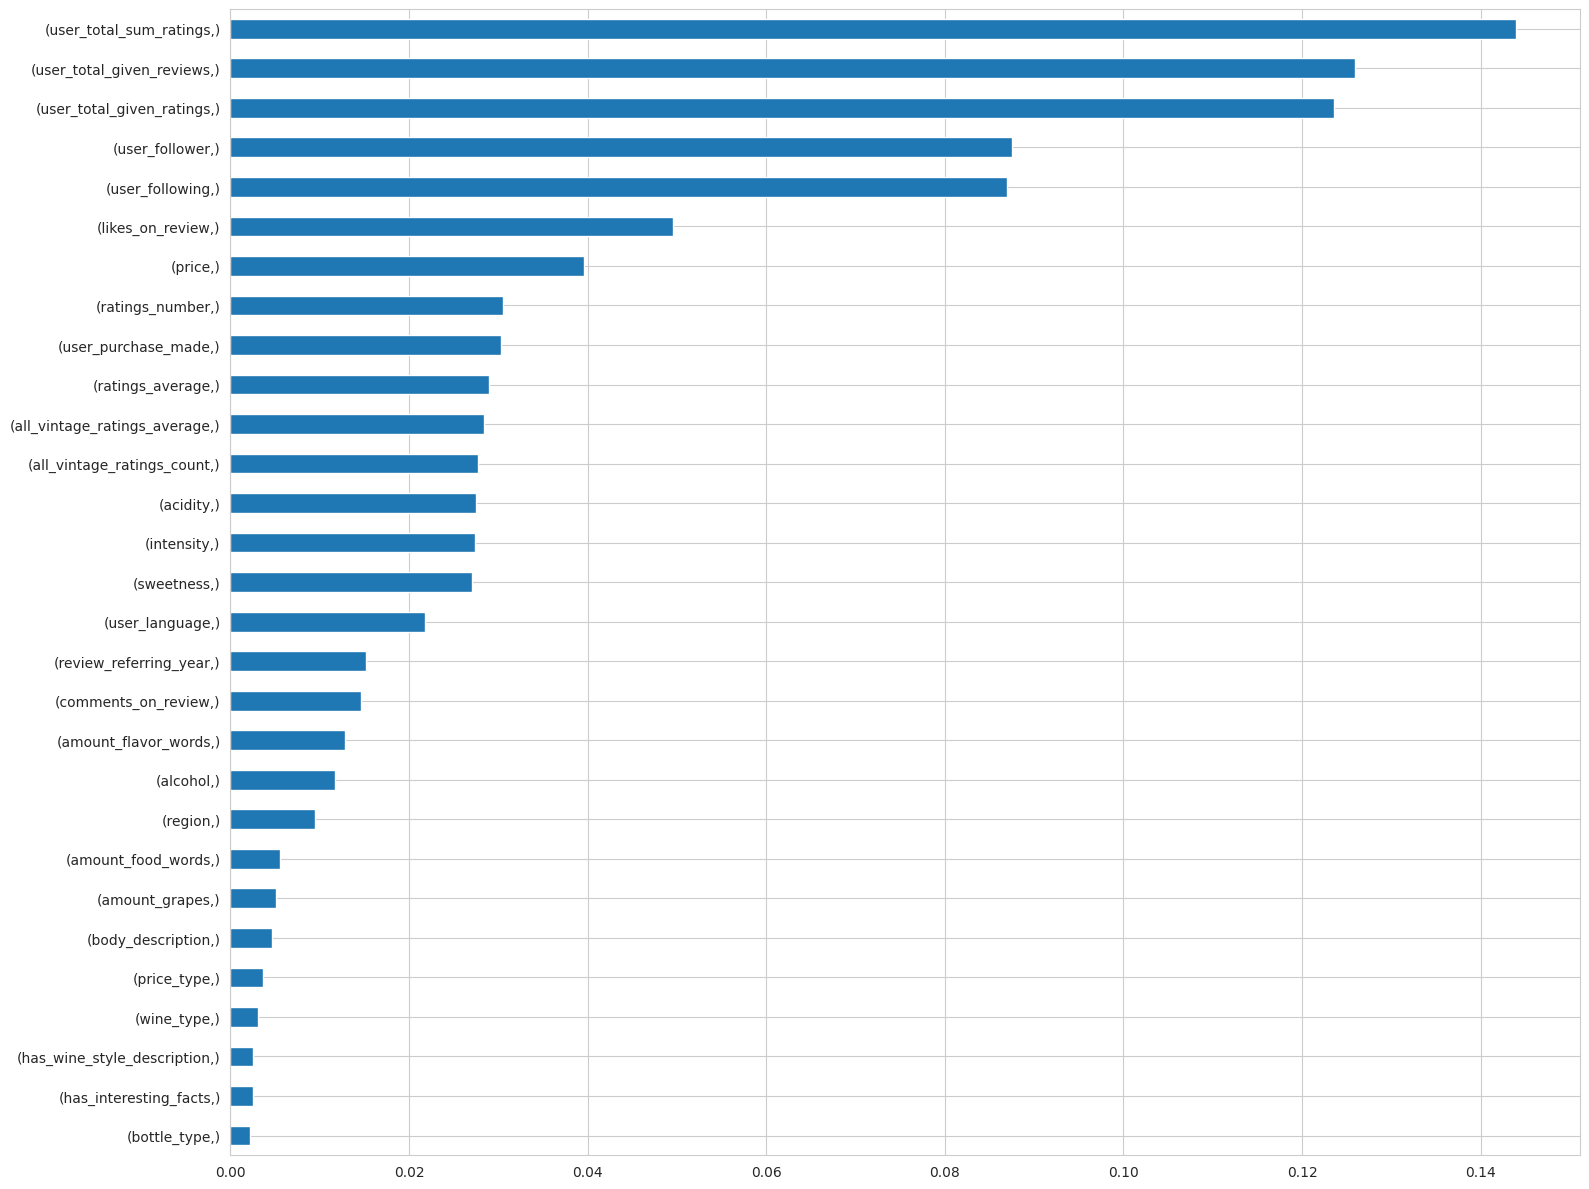

In [ ]:
evaluate(best_model)